# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while. 
We recommend setting several variables here that prevent repeating long-running tasks.

In [ ]:
device = 'cpu' # TODO change to GPU if you have one (e.g. on Colab)

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`. 

That will let us use the starter code in this notebook. 

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [ ]:
if COLAB:
    !cd drive/MyDrive/ && mkdir CS152L3D_2024f && cd CS152L3D_2024f/ && mkdir HW1

In [ ]:
# Move notebook working directory into the folder
if COLAB:
    %cd drive/MyDrive/CS152L3D_2024f/HW1

    # Clone the repo
    !git clone <link>

    #cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [ ]:
!ls ../

a.jpg			    core.73695				README.md
birdsnap10		    data_raw				src_solution
birdsnap10_224x224only.zip  imagenet_classes.txt		src_starter
classes.txt		    mobilenet_w1-0895-7e1d739f.pth	tex_solution
core.200751		    mobilenet_w1_cub-2377-8428471f.pth	zzz_deprecated
core.201636		    mobilenet_wd4-2249-1ad5e8fe.pth
core.267762		    panos


In [ ]:
if COLAB:
    !pip install -r requirements.txt

In [ ]:
import sys
import os

In [ ]:
DATA_DIR = os.path.abspath('../birdsnap10')

In [ ]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

# Import Libraries

In [ ]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [ ]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);

# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [ ]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=4910922 over 38 tensors in layers: features.init_block.conv.conv,features.init_block.conv.bn,features.stage1.unit1.body.conv1.conv,features.stage1.unit1.body.conv1.bn,features.stage1.unit1.body.conv2.conv,features.stage1.unit1.body.conv2.bn,features.stage2.unit1.body.conv1.conv,features.stage2.unit1.body.conv1.bn,features.stage2.unit1.body.conv2.conv,features.stage2.unit1.body.conv2.bn,features.stage2.unit1.identity_conv.conv,features.stage2.unit1.identity_conv.bn,features.stage3.unit1.body.conv1.conv,features.stage3.unit1.body.conv1.bn,features.stage3.unit1.body.conv2.conv,features.stage3.unit1.body.conv2.bn,features.stage3.unit1.identity_conv.conv,features.stage3.unit1.identity_conv.bn,features.stage4.unit1.body.conv1.conv,features.stage4.unit1.body.conv1.bn,features.stage4.unit1.body.conv2.conv,features.stage4.unit1.body.conv2.bn,features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


Pretty-print layer-by-layer info

In [ ]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    9,536
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    73,984
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   230,144
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   919,040
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     3,673,088
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]            5,130


# Load dataset

In [ ]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
data_utils.BirdsnapDataset(DATA_DIR)

Dataset BirdsnapDataset
    Number of datapoints: 1407
    Root location: /cluster/tufts/hugheslab/code/cs152l3d-24f-staffonly/hw_src/hw1/birdsnap10

In [ ]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 50 50 50 50 50 50 50 50 50 50


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [ ]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            pass # TODO FIXME
            # Count number of correct predictions across all batches of provided loader
    return correct / len(test_loader) 

# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [ ]:
if PROB1_EXPERIMENTS:
    seed = 42
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet10_in, device, train_loader, val_loader, 
        n_epochs=3,
        lr=0.001,
        l2pen_mag=0, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )



Setup complete. Trainable parameter count=4910922 over 38 tensors in layers: features.init_block.conv.conv,features.init_block.conv.bn,features.stage1.unit1.body.conv1.conv,features.stage1.unit1.body.conv1.bn,features.stage1.unit1.body.conv2.conv,features.stage1.unit1.body.conv2.bn,features.stage2.unit1.body.conv1.conv,features.stage2.unit1.body.conv1.bn,features.stage2.unit1.body.conv2.conv,features.stage2.unit1.body.conv2.bn,features.stage2.unit1.identity_conv.conv,features.stage2.unit1.identity_conv.bn,features.stage3.unit1.body.conv1.conv,features.stage3.unit1.body.conv1.bn,features.stage3.unit1.body.conv2.conv,features.stage3.unit1.body.conv2.bn,features.stage3.unit1.identity_conv.conv,features.stage3.unit1.identity_conv.bn,features.stage4.unit1.body.conv1.conv,features.stage4.unit1.body.conv1.bn,features.stage4.unit1.body.conv2.conv,features.stage4.unit1.body.conv2.bn,features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


100%|████████████████████████████| 4/4 [01:29<00:00, 22.46s/it, tr_xent=0.457, tr_err=0.932, va_xent=0, va_err=0.95, batch_done=7]

Finished after epoch 3, best epoch=3
best va_xent 0.000
best tr_err 0.932
best va_err 0.950


# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't make sense until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15). 

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

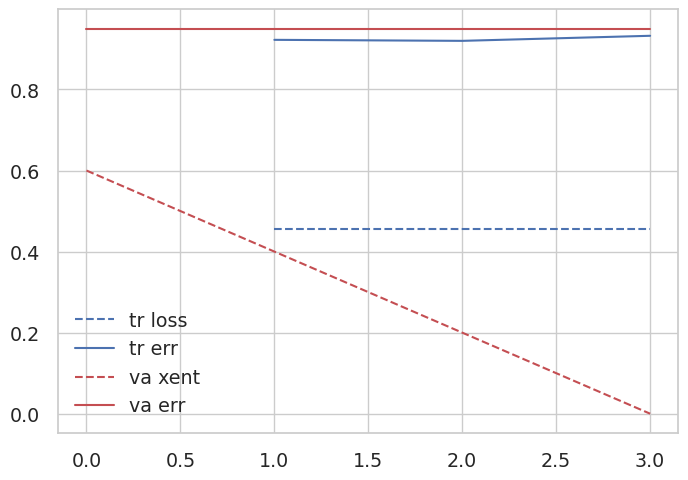

In [ ]:
plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

In [ ]:
'''
if os.path.exists(PROB1_res_file):
    with open(PROB1_res_file, 'rb') as f:
        results = pickle.load(f)
else:
    results = dict()
    
results[(src_dataset, arch)] = best_model, best_info

with open(PROB1_res_file, 'w') as f:
    f.save(results)
''';

**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

In [ ]:
# TODO do tuning expts for Resnet10, CUB

In [ ]:
# TODO do tuning expts for Resnet26, ImageNet1k

In [ ]:
# TODO do tuning expts for Resnet26, CUB

# Problem 1 Analysis and Plotting

In [ ]:
# Create dummy results so we can show what kind of plots we want
dummy_result = {}

eps = np.arange(20)

dummy_result[('ResNet10', 'ImageNet1k')] = dict(
    lr = 0.123,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=eps,
    tr=dict(
        loss=.7 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        xent=.68 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        err=.01 * np.ones(20),
    ),
    va=dict(
        xent=.8 - .2 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        err=.1 * np.ones(20),
    ),
    best_epoch=10,
    best_va_loss=0.6,
)

eps = np.arange(30)
dummy_result[('ResNet10', 'CUB')] = dict(
    lr = 0.456,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=eps,
    tr=dict(
        loss=.7 - .3 * (1 - np.abs(eps-15) / 15),  # upside-down triangle
        xent=.68 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
        err=.01 * np.ones(30),
    ),
    va=dict(
        xent=.9 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
        err=.1 * np.ones(30),
    ),
    best_epoch=15,
    best_va_loss=0.6,
)

## Figure 1a: Loss over Epochs 

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

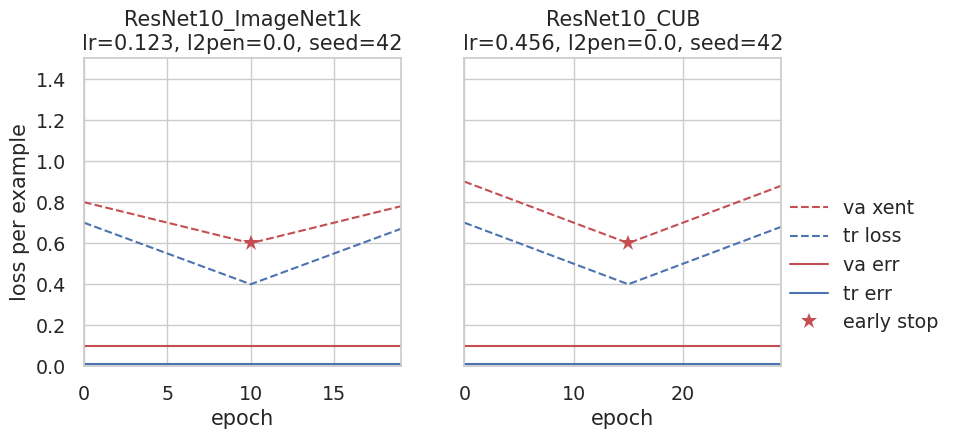

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
        ('ResNet10','ImageNet1k'),
        ('ResNet10','CUB'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)
    info = dummy_result[key]
    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [ ]:
src_acc = {}
src_acc[('ResNet10', 'ImageNet1k')] = 0.5 # TODO FIXME
src_acc[('ResNet26', 'ImageNet1k')] = 0.9 # TODO FIXME

src_acc[('ResNet10', 'CUB')] = 0.5 # TODO FIXME
src_acc[('ResNet26', 'CUB')] = 0.9 # TODO FIXME

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [ ]:
tar_acc = {}
tar_acc[('ResNet10', 'ImageNet1k')] = 0.5 # TODO FIXME
tar_acc[('ResNet26', 'ImageNet1k')] = 0.9 # TODO FIXME

tar_acc[('ResNet10', 'CUB')] = 0.5 # TODO FIXME
tar_acc[('ResNet26', 'CUB')] = 0.9 # TODO FIXME

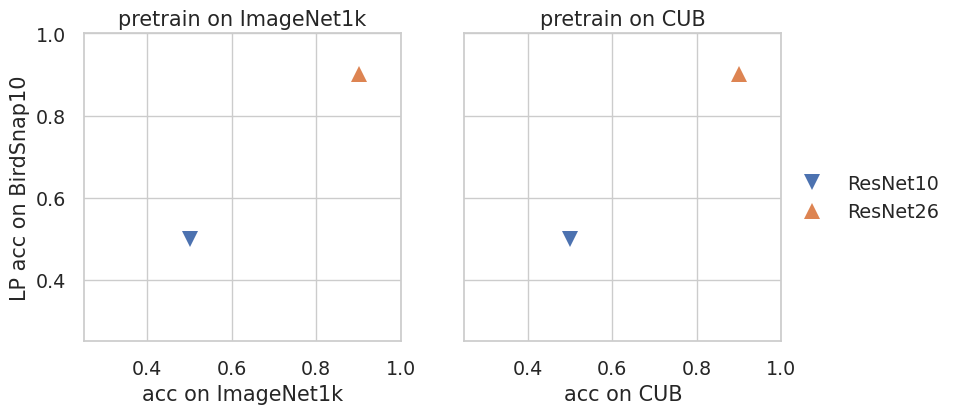

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(arch, src_dataset)]
    cur_src_acc = src_acc[(arch, src_dataset)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [ ]:
eps = np.arange(20)

P2_dummy_result = {}

# Phase 1, copy hard work from Problem 1
P2_dummy_result[('ResNet10', 'ImageNet1k','phase1')] = dummy_result[('ResNet10', 'ImageNet1k')]

eps = np.arange(20)
P2_dummy_result[('ResNet10', 'ImageNet1k','phase2')] = dict(
    lr = 0.456,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=np.arange(20),
    tr=dict(
        loss=.3 - 0.15 * (eps/max(eps)),
        err=.01 * np.ones(20),
    ),
    va=dict(
        xent=.6 - 0.15 * (eps/max(eps)),
        err=.1 * np.ones(20),
    ),
    best_epoch=10,
    best_va_loss=0.6,
    test_acc=0.1,
)

## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

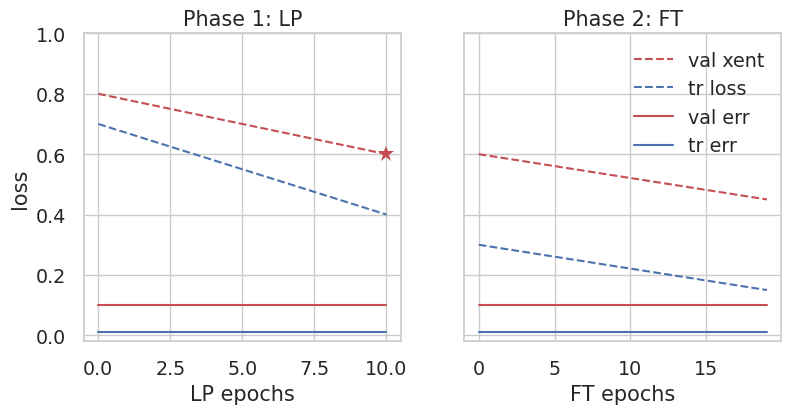

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase2')]

# Only show LP phase until early stop occurs
eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].set_title("Phase 2: FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('FT epochs');
axgrid[1].legend(loc='upper right');


## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [ ]:
# TODO compute test acc after the LP phase

In [ ]:
# TODO compute test acc after the FT-3 phase